In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Load the train and test dataset and the UNET model with the appropriate string extension!

In [3]:
train_images = np.load("project3_data/augmented_data_20/images_train.npy")
train_labels = np.load("project3_data/augmented_data_20/labels_train.npy")

test_images = np.load("project3_data/augmented_data_20/images_test.npy")
test_labels = np.load("project3_data/augmented_data_20/labels_test.npy")

print("Original image shape: %s" % (train_images.shape,))
print("Original label shape: %s" % (train_labels.shape,))
print("Image dtype: %s, Label dtype: %s" % (train_images.dtype, train_labels.dtype))

string = '32F25Dr3WsreA5D'  # string indicating the set of parameters to load
print("UNET parameters selection: " + string)

U_net = tf.keras.models.load_model('models/U_net_' + string)  # load the UNET

file_path = "models/U_net_" + string + ".h5"  # file to save the weights
checkpoint = ModelCheckpoint(file_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]

FileNotFoundError: [Errno 2] No such file or directory: 'project3_data/augmented_data_20/labels_train.npy'

## Compute weights for each class

In [3]:
ct0=[]
ct1=[]
ct2=[]
for i in range(0, train_labels.shape[0]):
    img = train_labels[i,:,:]
    mask = np.zeros((img.shape[0], img.shape[1], 3))
    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==0))
    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==1))
    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==2))
    ct0.append(np.sum(mask[:,:,0]))
    ct1.append(np.sum(mask[:,:,1]))
    ct2.append(np.sum(mask[:,:,2]))
sum_all= sum(ct0)+sum(ct1)+sum(ct2)
wt0= 1-(sum(ct0)/sum_all)
wt1= 1-(sum(ct1)/sum_all)
wt2= 1-(sum(ct2)/sum_all)
print(wt0, wt1, wt2)

0.0641933223697182 0.9789458533080909 0.9568608243221908


## Normalize the input images

In [4]:
def normalize(image):
    denominator = np.amax(image)
    return image/denominator

print("Range of input values: %s" % {np.amin(train_images), np.amax(train_images)})

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

for i in range(train_images.shape[0]):
    train_images[i] = normalize(train_images[i])
for i in range(test_images.shape[0]):
    test_images[i] = normalize(test_images[i])
    
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

print("Normalized range of input values: %s" % {np.amin(train_images), np.amax(train_images)})
print("Normalized input image shape: %s" % (train_images.shape,))
print("Normalized image dtype: %s" % (train_images.dtype))

Range of input values: {0, 1890}
Normalized range of input values: {0.0, 1.0}
Normalized input image shape: (13472, 256, 256, 1)
Normalized image dtype: float32


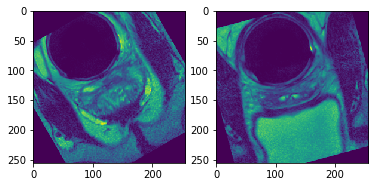

In [5]:
plt.subplot(1,2,1)
plt.imshow(train_images[1,:,:,0])
plt.subplot(1,2,2)
plt.imshow(test_images[1,:,:,0])

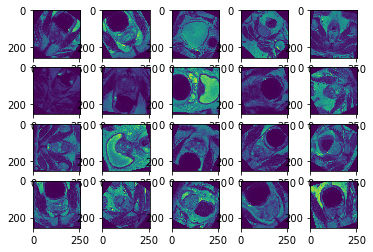

In [6]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(train_images[i,:,:,0])

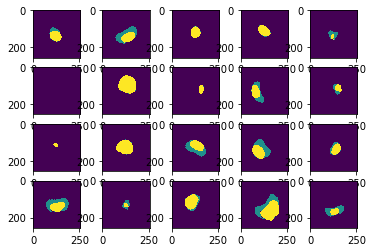

In [7]:
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(train_labels[i,:,:])

## Convert the training labels to categorical vectors

In [8]:
new_train_labels = np.reshape(train_labels, [train_labels.shape[0], train_labels.shape[1]*train_labels.shape[2]])
train_labels = new_train_labels
print("Vectorized new label shape: %s" % (train_labels.shape,))

Vectorized new label shape: (13472, 65536)


## Train the UNET

In [9]:
history = U_net.fit(train_images, train_labels, epochs = 5, validation_split = 0.2, verbose = 1, 
                    callbacks = callbacks_list, class_weight = [wt0, wt1, wt2])

Train on 10777 samples, validate on 2695 samples
Epoch 1/5
10777/10777 [==============================] - 12656s 1s/sample - loss: 0.1485 - accuracy: 0.9486 - val_loss: 0.5160 - val_accuracy: 0.7910


C:\Users\geors\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/5
10777/10777 [==============================] - 12893s 1s/sample - loss: 0.1016 - accuracy: 0.9611 - val_loss: 0.1405 - val_accuracy: 0.9616
Epoch 3/5
10777/10777 [==============================] - 9338s 867ms/sample - loss: 0.0825 - accuracy: 0.9690 - val_loss: 0.1203 - val_accuracy: 0.9589
Epoch 4/5
10777/10777 [==============================] - 8604s 798ms/sample - loss: 0.0713 - accuracy: 0.9737 - val_loss: 0.1075 - val_accuracy: 0.9624
Epoch 5/5
10777/10777 [==============================] - 8909s 827ms/sample - loss: 0.0630 - accuracy: 0.9769 - val_loss: 0.0817 - val_accuracy: 0.9723


## Get predicted labels

In [10]:
U_net.save_weights(file_path)
U_net.load_weights(file_path)
test_labels_pred = U_net.predict(test_images)

## Evaluate the U-net: Overall precision, Per-class precision, IoU

In [11]:
print("Shape of test labels: %s \nShape of predicted labels: %s" % (test_labels.shape, test_labels_pred.shape))
new_test_labels = np.reshape(test_labels, [test_labels.shape[0], test_labels.shape[1]*test_labels.shape[2]])
print("New test labels shape: %s " % (new_test_labels.shape,))

Shape of test labels: (3368, 256, 256) 
Shape of predicted labels: (3368, 65536, 3)
New test labels shape: (3368, 65536) 


In [12]:
test_labels_pred = np.argmax(test_labels_pred, axis=-1)
print("New predicted labels shape: %s " % (test_labels_pred.shape,))

New predicted labels shape: (3368, 65536) 


In [13]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='macro'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='macro'))
    return results
get_scores(new_test_labels, test_labels_pred)

[0.9726252431257887, 0.8612158826700435, 0.6707649272439257]

In [14]:
def get_scores(y_true, y_pred):
    results=[]
    y_true=y_true.flatten()
    y_pred=y_pred.flatten()
    #Overall precision
    results.append(metrics.precision_score(y_true, y_pred, average='micro'))
    #Per-class precision
    results.append(metrics.precision_score(y_true, y_pred, average='weighted'))
    #jaccard (right average?)
    results.append(metrics.jaccard_score(y_true, y_pred, average='weighted'))
    return results
get_scores(new_test_labels, test_labels_pred)

[0.9726252431257887, 0.9697612639642913, 0.9494030697836255]

## Plot outcome as Confusion Matrix

In [15]:
# reshape back to original dimensions
test_labels_pred_org = np.reshape(test_labels_pred, [test_labels_pred.shape[0], 256, 256])
test_labels_pred_org.shape

(3368, 256, 256)

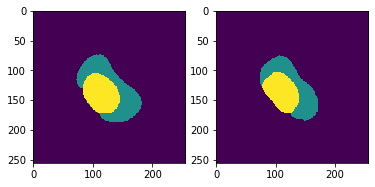

In [16]:
# plot an example of original label VS predicted label
ind = 2
plt.subplot(1,2,1)
plt.imshow(test_labels[ind])
plt.subplot(1,2,2)
plt.imshow(test_labels_pred_org[ind])

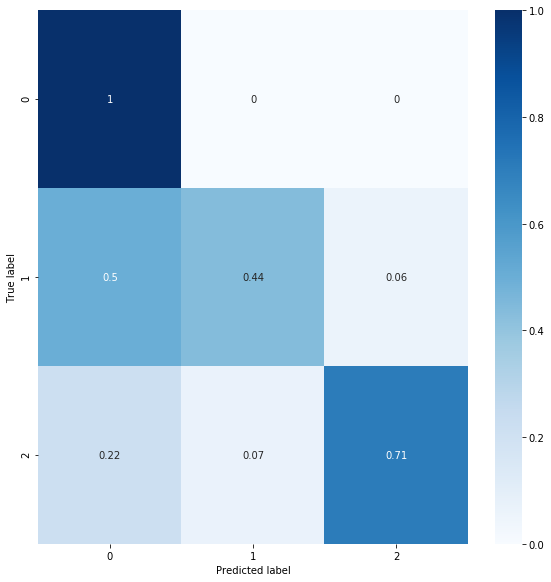

In [17]:
classes=[0,1,2]

con_mat = tf.math.confusion_matrix(labels=new_test_labels.flatten(), predictions=test_labels_pred.flatten()).numpy()

# Normalization of Confusion Matrix to the interpretation of which class is being misclassified.
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

# plot confusion matrix
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()